In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F
from torch import Tensor

from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import os

print(os.getcwd()) # dosya yolunu ver
%run ../Model.ipynb
%run ../Dataset.ipynb

%run ./Flow_Model.ipynb

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

/arf/home/tunal/ondemand/PhD Thesis Starting/01_SON/Tik-4/Tez/06-Cifar_10/05-UAE_Latent_FM


In [2]:
# Dataset
test_dataset = CIFAR10Dataset(mode='test')
# DataLoader
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

In [3]:
# UAE modelini çalıştır

path = '../02-UAE_for_Cifar_10/results/UAE_Cifar_10'
model = torch.load(path + '.model', weights_only=False, map_location='cpu')
model.eval()

To_Uniform(
  (encoder): SimpleEncoder(
    (conv1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): 

In [4]:
# "results" klasörünü oluştur (zaten varsa hata vermez)
os.makedirs("results", exist_ok=True)

flow_name = 'results/UAE_Latent_FM'
model_eval = torch.load(flow_name + '.model', weights_only=False, map_location='cpu')
model_eval.eval()

Flow(
  (net): Sequential(
    (0): Linear(in_features=257, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1000, out_features=1000, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1000, out_features=1000, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1000, out_features=1000, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1000, out_features=1000, bias=True)
    (13): ReLU()
    (14): Linear(in_features=1000, out_features=256, bias=True)
  )
)

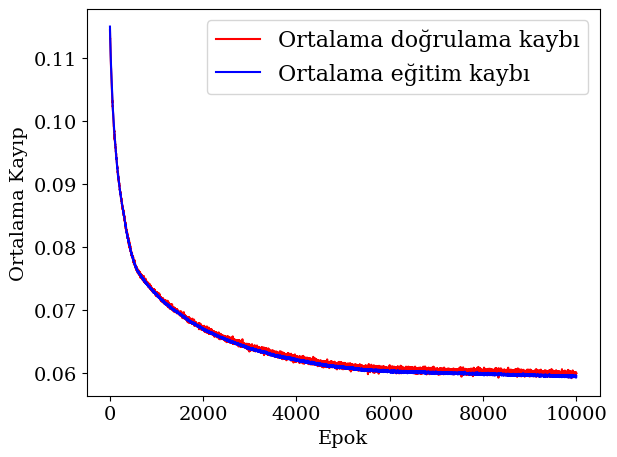

In [120]:
# Kayıpları yükle
losses = np.loadtxt("results/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Grafik oluştur
plt.plot(val_losses, label="Ortalama doğrulama kaybı", c="red")
plt.plot(train_losses, label="Ortalama eğitim kaybı", c="blue")

plt.xlabel("Epok")
plt.ylabel("Ortalama Kayıp")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("results/average_losses_per_epoch.pdf")
plt.show()

In [121]:
# Initialize uniform random data (3D)
x_uniform = torch.rand(len(test_dataset), 256)
n_steps = 8

# Create time steps
time_steps = torch.linspace(0, 1.0, n_steps + 1)


for i in range(n_steps):
    x_uniform = model_eval.step(x_t=x_uniform, t_start=time_steps[i], t_end=time_steps[i + 1])

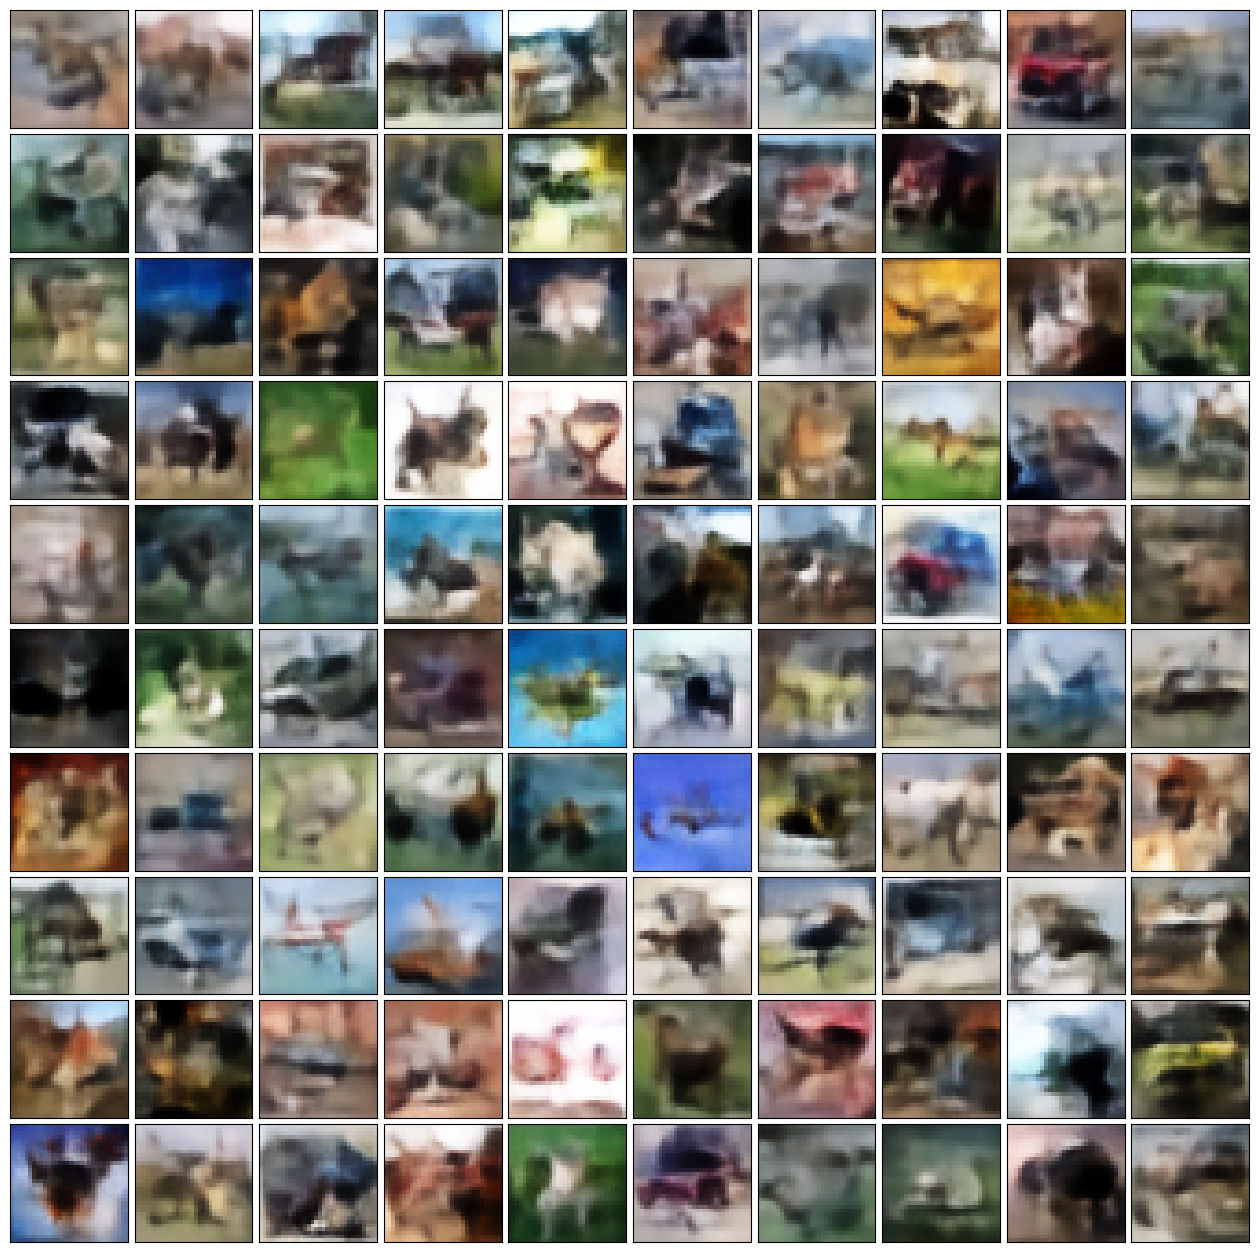

In [122]:
# Decode et
x_hat = model.decoder(x_uniform).view(-1, 3, 32, 32)

# Görselleştir
fig, axs = plt.subplots(10, 10, figsize=(16, 16), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i, ax in enumerate(axs.flat):
    img = x_hat[i].reshape(3, 32, 32).permute(1, 2, 0).detach().numpy()
    ax.imshow(img, interpolation='nearest')

plt.savefig('./results/cifar10_veri_uretimi_from_latent_FM.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

Kedi
Gemi
Köpek
Geyik


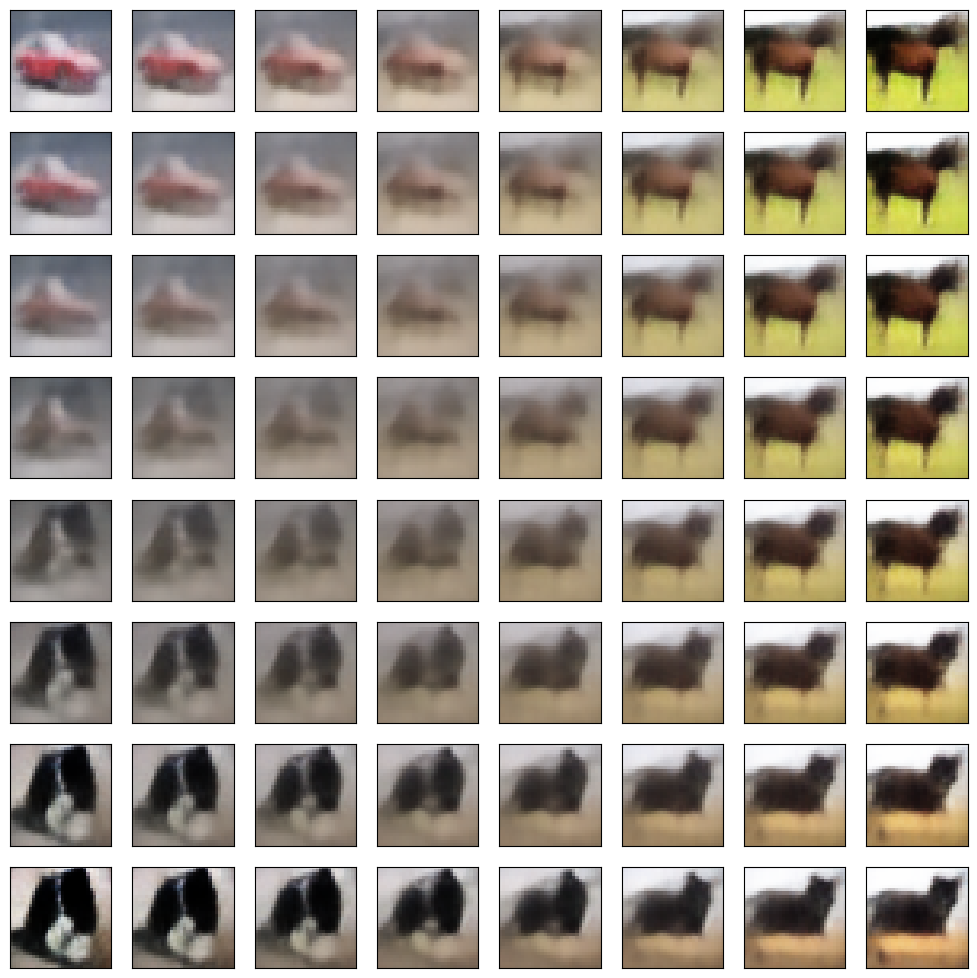

In [125]:
import torch
from itertools import product
device = 'cpu'

classes = ['Uçak', 'Araba', 'Kuş', 'Kedi', 'Geyik',
           'Köpek', 'Kurbağa', 'At', 'Gemi', 'Kamyon']

# --- 1. Unique class corner selection ---
unique_indices = []
unique_labels = set()

while len(unique_indices) < 4:
    i = torch.randint(0, len(test_dataset), (1,)).item()
    label = test_dataset[i][1]

    if label not in unique_labels:   # daha önce alınmamış sınıf
        unique_labels.add(label)
        unique_indices.append(i)

# göster
for idx in unique_indices:
    print(classes[test_dataset[idx][1]])
    #print(idx)
    
# 4 köşe latentleri
x1 = model.encoder(test_dataset[2694][0].unsqueeze(0).to(device))  # top-left
x2 = model.encoder(test_dataset[9399][0].unsqueeze(0).to(device))  # top-right
x3 = model.encoder(test_dataset[9985][0].unsqueeze(0).to(device))  # bottom-left
x4 = model.encoder(test_dataset[2815][0].unsqueeze(0).to(device))  # bottom-right
"""
# 4 köşe latentleri
x1 = model.encoder(test_dataset[unique_indices[0]][0].unsqueeze(0).to(device))  # top-left
x2 = model.encoder(test_dataset[unique_indices[1]][0].unsqueeze(0).to(device))  # top-right
x3 = model.encoder(test_dataset[unique_indices[2]][0].unsqueeze(0).to(device))  # bottom-left
x4 = model.encoder(test_dataset[unique_indices[3]][0].unsqueeze(0).to(device))  # bottom-right
"""

# 2. Bilinear interpolasyon fonksiyonu
def bilinear_interp(z_tl, z_tr, z_bl, z_br, x, y):
    return (
        (1 - x) * (1 - y) * z_tl +
        x * (1 - y) * z_tr +
        (1 - x) * y * z_bl +
        x * y * z_br
    )

# 3. Interpolasyon grid'i oluştur (örneğin 8x8)
n_steps = 8
grid_z = []

for i, j in product(range(n_steps), range(n_steps)):
    xi = j / (n_steps - 1)
    yi = i / (n_steps - 1)
    z = bilinear_interp(x1, x2, x3, x4, xi, yi)  # [1, latent_dim]
    
    # 4. Flow modeli ile step-by-step çöz
    z_interp = z.clone()
    time_steps = torch.linspace(0, 1.0, 9).to(device)

    for k in range(len(time_steps) - 1):
        z_interp = model_eval.step(x_t=z_interp, t_start=time_steps[k], t_end=time_steps[k+1])
    
    grid_z.append(z_interp)

# 5. Decode et ve görselleştir (örnek CIFAR-10 için)
fig, axes = plt.subplots(n_steps, n_steps, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for i in range(n_steps):
    for j in range(n_steps):
        index = i * n_steps + j
        decoded_img = model.decoder(grid_z[index]).squeeze(0).cpu().permute(1, 2, 0).clip(0, 1)
        axes[i, j].imshow(decoded_img.detach().numpy())

plt.tight_layout()
plt.savefig('./results/cifar10_flow_corner_interp.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Rasgele uniform dağılımdan alınan sample lar ile interpolasyon

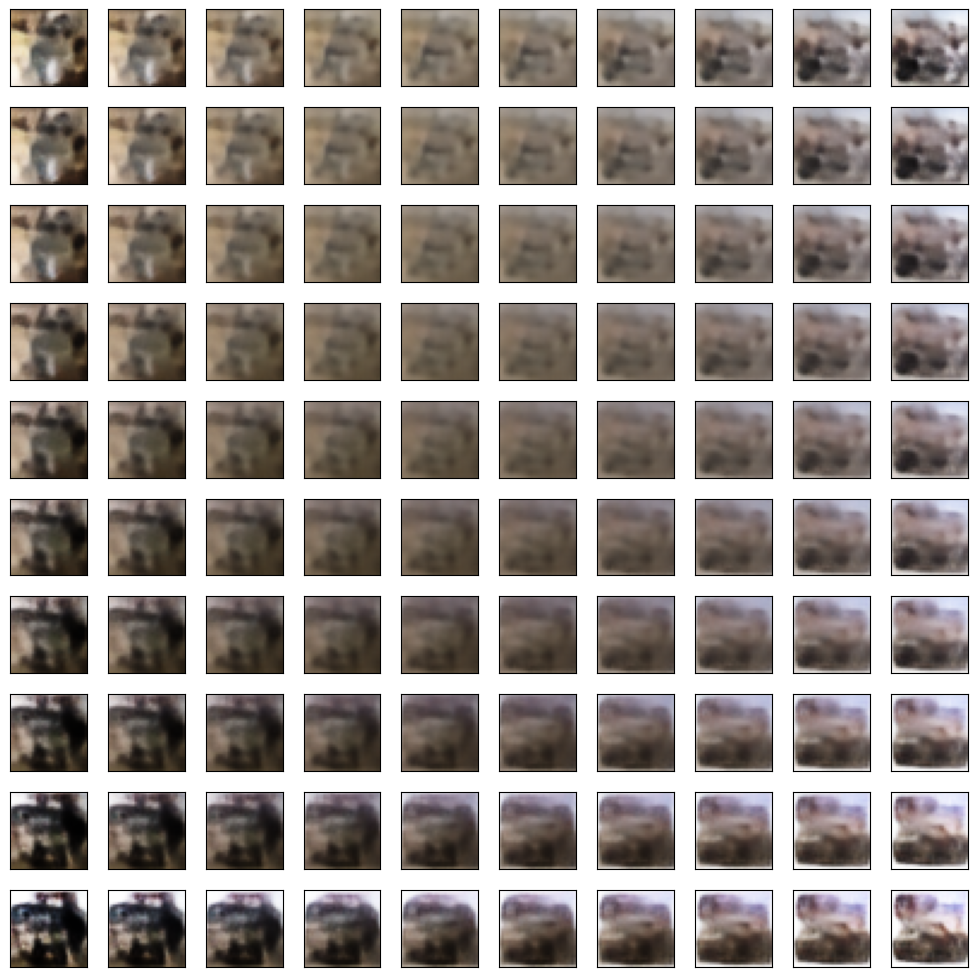

In [124]:
from itertools import product

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Rastgele 4 latent vektör üret (örneğin latent_dim=300)
latent_dim = 256
z_tl = torch.rand(1, latent_dim, device=device)  # Top-left
z_tr = torch.rand(1, latent_dim, device=device)  # Top-right
z_bl = torch.rand(1, latent_dim, device=device)  # Bottom-left
z_br = torch.rand(1, latent_dim, device=device)  # Bottom-right

# 2. Bilinear interpolasyon fonksiyonu
def bilinear_interp(z_tl, z_tr, z_bl, z_br, x, y):
    return (
        (1 - x) * (1 - y) * z_tl +
        x * (1 - y) * z_tr +
        (1 - x) * y * z_bl +
        x * y * z_br
    )

# 3. Interpolasyon ve flow çözüm adımları
n_steps = 10
grid_z = []

for i, j in product(range(n_steps), range(n_steps)):
    xi = j / (n_steps - 1)
    yi = i / (n_steps - 1)
    z = bilinear_interp(z_tl, z_tr, z_bl, z_br, xi, yi)

    # Flow çözümü (isteğe bağlı, varsa kullanılabilir)
    time_steps = torch.linspace(0, 1.0, 9).to(device)
    z_interp = z.clone()
    for k in range(len(time_steps) - 1):
        z_interp = model_eval.step(x_t=z_interp, t_start=time_steps[k], t_end=time_steps[k + 1])
    
    grid_z.append(z_interp)

# 4. Decode edip görselleştir
fig, axes = plt.subplots(n_steps, n_steps, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for i in range(n_steps):
    for j in range(n_steps):
        index = i * n_steps + j
        decoded_img = model.decoder(grid_z[index]).squeeze(0).cpu().permute(1, 2, 0).clip(0, 1)
        axes[i, j].imshow(decoded_img.detach().numpy())

plt.tight_layout()
plt.savefig('./results/cifar10_uniform_corner_interp_grid.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()


Satır 0: Uçak -> left idx 7929, right idx 7038
Satır 1: Araba -> left idx 4516, right idx 3460
Satır 2: Kuş -> left idx 1254, right idx 9965
Satır 3: Kedi -> left idx 4965, right idx 5458
Satır 4: Geyik -> left idx 3967, right idx 5150
Satır 5: Köpek -> left idx 3192, right idx 2915
Satır 6: Kurbağa -> left idx 7606, right idx 7317
Satır 7: At -> left idx 8050, right idx 3327
Satır 8: Gemi -> left idx 6366, right idx 9023
Satır 9: Kamyon -> left idx 921, right idx 6381


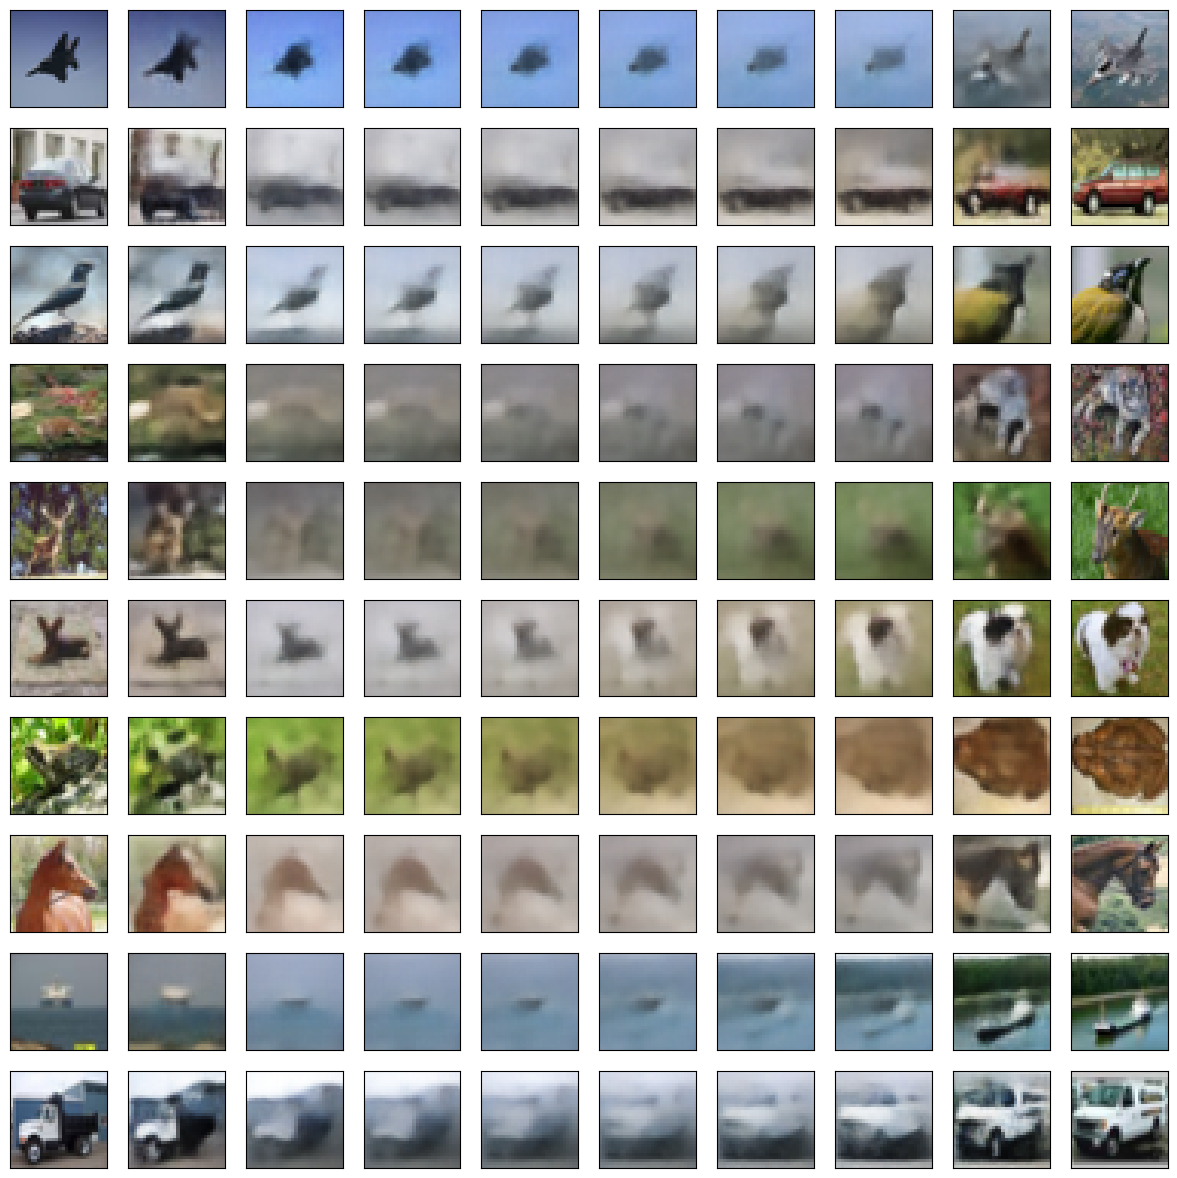

In [13]:
import torch
from itertools import product
import matplotlib.pyplot as plt

device = "cpu"

classes = ['Uçak', 'Araba', 'Kuş', 'Kedi', 'Geyik',
           'Köpek', 'Kurbağa', 'At', 'Gemi', 'Kamyon']

# 1) Her sınıf için test setinden index listesi çıkar
class_to_indices = {c: [] for c in range(10)}
for idx in range(len(test_dataset)):
    label = test_dataset[idx][1]
    class_to_indices[label].append(idx)

# 2) Her satır için aynı sınıftan iki farklı örnek seç (sol-sağ)
row_pairs = []
for c in range(10):
    inds = class_to_indices[c]
    pair = torch.randperm(len(inds))[:2].tolist()
    i_left, i_right = inds[pair[0]], inds[pair[1]]
    row_pairs.append((i_left, i_right))

    print(f"Satır {c}: {classes[c]} -> left idx {i_left}, right idx {i_right}")

# Lineer interpolasyon fonksiyonu
def linear_interp(z_left, z_right, alpha):
    return (1 - alpha) * z_left + alpha * z_right

# Grid ayarları
n_rows = 10
n_cols = 10
grid_imgs = [[None for _ in range(n_cols)] for _ in range(n_rows)]

time_steps = torch.linspace(0, 1.0, 9).to(device)

for r in range(n_rows):
    idx_left, idx_right = row_pairs[r]

    # Orijinal img'ler
    img_left  = test_dataset[idx_left][0].unsqueeze(0).to(device)
    img_right = test_dataset[idx_right][0].unsqueeze(0).to(device)

    # Encode
    z_left  = model.encoder(img_left)
    z_right = model.encoder(img_right)

    # Reconstructions
    recon_left  = model.decoder(z_left).squeeze(0).cpu()
    recon_right = model.decoder(z_right).squeeze(0).cpu()

    # --- 1. sütun: gerçek sol görüntü ---
    grid_imgs[r][0] = img_left.squeeze(0).cpu().permute(1, 2, 0)

    # --- 2. sütun: reconstruction sol ---
    grid_imgs[r][1] = recon_left.permute(1, 2, 0)

    # --- 3–8: interpolasyon + flow ---
    for c in range(2, 8):
        alpha = (c - 1) / 7.0  # 6 ara adım
        z_interp = linear_interp(z_left, z_right, alpha)

        # flow step-by-step çöz
        z_flow = z_interp.clone()
        for k in range(len(time_steps) - 1):
            z_flow = model_eval.step(
                x_t=z_flow,
                t_start=time_steps[k],
                t_end=time_steps[k+1]
            )

        img_interp = model.decoder(z_flow).squeeze(0).cpu()
        grid_imgs[r][c] = img_interp.permute(1, 2, 0)

    # --- 9. sütun: reconstruction sağ ---
    grid_imgs[r][8] = recon_right.permute(1, 2, 0)

    # --- 10. sütun: gerçek sağ görüntü ---
    grid_imgs[r][9] = img_right.squeeze(0).cpu().permute(1, 2, 0)



# 5) Decode + görselleştir
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

for r in range(n_rows):
    for c in range(n_cols):
        axes[r, c].imshow(grid_imgs[r][c].clamp(0, 1).detach().numpy())

plt.tight_layout()
plt.savefig("./results/cifar10_flow_rowwise_sameclass_interp_full.pdf",
            format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()
